### S30 - RUTINA GENERACIÓN DE GRÁFICOS.

Parte de los forecast executión que están en estado 30 (Ya Ejecutado el Forecast), Genera en los archivos locales de detalle los gráficos a nivel línea,

Los deja en archivos locales algoritmo_Pronostico_Extendido y Actualiza esl estado de 30 a 40  Graficos OK

### RUTINA GENERADORA DE GRÁFICOS

1) Leer archivo Solicitudes_Compra
2) Leer datos adicionales y id relacionados
3) Leer datos adicionales de la T710_Estadis_Reposición
4) Generar GRAFICOS
5) Actulizar Estado en connexa

In [1]:
# RUTINA GENERADORA GLOBAL DE GRÄRICOS
import base64
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
# LIBRERIAS NECESARIAS 
from datetime import datetime, timedelta
import numpy as np
from dotenv import dotenv_values
import psycopg2 as pg2    # Conectores para Postgres
import getpass  # Para obtener el usuario del sistema operativo
import uuid  # Importar la librería uuid
# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

secrets = dotenv_values(".env")   # Connection String from .env
folder = secrets["FOLDER_DATOS"]


### RUTINAS LOCALES de PRUEBA

In [ ]:
# Funciones de conexión a la base de datos
def Open_Conn_Postgres():
    secrets = dotenv_values(".env")   # Cargar credenciales desde .env    
    conn_str = f"dbname={secrets['BASE4']} user={secrets['USUARIO4']} password={secrets['CONTRASENA4']} host={secrets['SERVIDOR4']} port={secrets['PUERTO4']}"
    try:    
        conn = pg2.connect(conn_str)
        return conn
    except Exception as e:
        print(f'Error en la conexión: {e}')
        return None

def Close_Connection(conn): 
    conn.close()
    return True

# Helper para generar identificadores únicos
def id_aleatorio():
    return str(uuid.uuid4())

def get_execution(execution_id):
    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        cur = conn.cursor()
        query = """
            SELECT id, description, name, "timestamp", supply_forecast_model_id, 
                ext_supplier_code, supplier_id, supply_forecast_execution_status_id
            FROM public.spl_supply_forecast_execution
            WHERE id = %s
        """
        cur.execute(query, (execution_id,))
        row = cur.fetchone()
        cur.close()
        if row:
            return {
                "id": row[0],
                "description": row[1],
                "name": row[2],
                "timestamp": row[3],
                "supply_forecast_model_id": row[4],
                "ext_supplier_code": row[5],
                "supplier_id": row[6],
                "supply_forecast_execution_status_id": row[7]
            }
        return None
    except Exception as e:
        print(f"Error en get_execution: {e}")
        return None
    finally:
        Close_Connection(conn)

def update_execution(execution_id, **kwargs):
    if not kwargs:
        print("No hay valores para actualizar")
        return None

    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        cur = conn.cursor()
        set_clause = ", ".join([f"{key} = %s" for key in kwargs.keys()])
        values = list(kwargs.values())
        values.append(execution_id)

        query = f"""
            UPDATE public.spl_supply_forecast_execution
            SET {set_clause}
            WHERE id = %s
        """
        cur.execute(query, tuple(values))
        conn.commit()
        cur.close()
        return get_execution(execution_id)  # Retorna la ejecución actualizada
    
    except Exception as e:
        print(f"Error en update_execution: {e}")
        conn.rollback()
        return None
    finally:
        Close_Connection(conn)

def get_execution_by_status(status):
    if not status:
        print("No hay estados para filtrar")
        return None
    
    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        query = f"""
        SELECT id, description, name, "timestamp", supply_forecast_model_id, ext_supplier_code, graphic, 
                monthly_net_margin_in_millions, monthly_purchases_in_millions, monthly_sales_in_millions, sotck_days, sotck_days_colors, 
                supplier_id, supply_forecast_execution_status_id
                FROM public.spl_supply_forecast_execution
                WHERE supply_forecast_execution_status_id = {status};
        """
        # Ejecutar la consulta SQL
        fexsts = pd.read_sql(query, conn)
        return fexsts
    except Exception as e:
        print(f"Error en get_execution_status: {e}")
        return None
    finally:
        Close_Connection(conn) 

def insertar_graficos_forecast(algoritmo, name, id_proveedor):
    # Recuperar Historial de Ventas
    df_ventas = pd.read_csv(f'{folder}/{name}_Ventas.csv')
    df_ventas['Codigo_Articulo']= df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal']= df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha']= pd.to_datetime(df_ventas['Fecha'])

    # Recuperar Maestro de Artículos
    articulos = pd.read_csv(f'{folder}/{name}_Articulos.csv')

    # Recuperando Forecast Calculado
    df_forecast = pd.read_csv(f'{folder}/{algoritmo}_Pronostico_Extendido.csv')
    df_forecast.fillna(0)   # Por si se filtró algún missing value
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")
    
    # Agregar la nueva columna de gráficos en df_forecast Iterando sobre todo el DATAFRAME
    df_forecast["GRAFICO"] = df_forecast.apply(
        lambda row: generar_grafico_base64(df_ventas, row["Codigo_Articulo"], row["Sucursal"], row["Forecast"], row["Average"], row["ventas_last"], row["ventas_previous"], row["ventas_same_year"]) if not pd.isna(row["Codigo_Articulo"]) and not pd.isna(row["Sucursal"]) else None,
        axis=1
    )
    
    # AGREGAR DATOS COMPLEMENTARIOS para Subir a CONNEXA
    conn =Open_Conn_Postgres()
    query = """
    SELECT code, name, id FROM public.fnd_site
    ORDER BY code 
    """
    # Ejecutar la consulta SQL
    stores = pd.read_sql(query, conn)
    # Intentar convertir el campo 'code' a int, eliminando las filas que no se puedan convertir
    stores = stores[pd.to_numeric(stores['code'], errors='coerce').notna()].copy()
    stores['code'] = stores['code'].astype(int)

    # Leer Dataframe de los PRODUCTOS
    conn =Open_Conn_Postgres()
    query = """
    SELECT ext_code, description, id FROM public.fnd_product
    ORDER BY ext_code;
    """
    # Ejecutar la consulta SQL
    products = pd.read_sql(query, conn)
    # Intentar convertir el campo 'code' a int, eliminando las filas que no se puedan convertir
    products = products[pd.to_numeric(products['ext_code'], errors='coerce').notna()].copy()
    products['ext_code'] = products['ext_code'].astype(int)

    #Unir los dataframes por Codigo_Articulo = ext_code
    df_merged = df_forecast.merge(products, left_on='Codigo_Articulo', right_on='ext_code', how='left')
    df_merged.rename(columns={'id': 'product_id'}, inplace=True)
    df_merged.drop(columns=['ext_code','description'], inplace=True)

    df_merged = df_merged.merge(stores, left_on = 'Sucursal', right_on='code', how='left')
    df_merged.rename(columns={'id': 'site_id'}, inplace=True)
    df_merged.drop(columns=['code','name'], inplace=True)
    
    # SUBIR INFORMACIÓN DE ARTICULOS y ESTIDISTICA REPOSICIÓN
    # Seleccionar las columnas requeridas en un nuevo dataframe  FALTA ,I_COSTO_ESTADISTICO,I_PRECIO_VTA
    columnas_seleccionadas = [
        'C_ARTICULO', 'C_SUCU_EMPR', 'F_ULTIMA_VTA', 'Q_VTA_ACUM', 'Q_UNID_PESO_VTA_MES_ACTUAL', 'Q_VTA_ULTIMOS_15DIAS',
        'Q_VTA_ULTIMOS_30DIAS', 'Q_TRANSF_PEND', 'Q_TRANSF_EN_PREP','Q_VENTA_30_DIAS',
        'Q_VENTA_15_DIAS', 'Q_VENTA_DOMINGO', 'Q_VENTA_ESPECIAL_30_DIAS','Q_VENTA_ESPECIAL_15_DIAS', 'Q_DIAS_CON_STOCK', 'Q_REPONER',
        'Q_REPONER_INCLUIDO_SOBRE_STOCK', 'Q_VENTA_DIARIA_NORMAL','Q_DIAS_STOCK', 'Q_DIAS_SOBRE_STOCK', 'Q_DIAS_ENTREGA_PROVEEDOR'
    ]

    # Filtrar el dataframe con las columnas seleccionadas
    df_nuevo = articulos[columnas_seleccionadas].copy()
    df_nuevo['C_SUCU_EMPR']= df_nuevo['C_SUCU_EMPR'].astype(int)
    
    # Realizar la fusión de los DataFrames utilizando 'Sucursal' y 'Codigo_Articulo' como claves
    df_merged = df_merged.merge(
        df_nuevo, 
        left_on=['Sucursal', 'Codigo_Articulo'], 
        right_on=['C_SUCU_EMPR', 'C_ARTICULO'], 
        how='left'
    )
    df_merged.drop(columns=['C_SUCU_EMPR','C_ARTICULO'], inplace=True)
    
    return df_merged



def generar_grafico_base64(dfv, articulo, sucursal, Forecast, Average, ventas_last, ventas_previous, ventas_same_year):
    fecha_maxima = dfv["Fecha"].max()
    df_filtrado = dfv[(dfv["Codigo_Articulo"] == articulo) & (dfv["Sucursal"] == sucursal)]
    df_filtrado = df_filtrado[df_filtrado["Fecha"] >= (fecha_maxima - pd.Timedelta(days=50))]

    fig, ax = plt.subplots(
        figsize=(8, 6), nrows= 2, ncols= 2
    )
    fig.suptitle(f"Demanda Articulo {articulo} - Sucursal {sucursal}")
    current_ax = 0
    #Bucle para Llenar los gráficos
    colors =["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

    # Ventas Diarias
    df_filtrado["Media_Movil"] = df_filtrado["Unidades"].rolling(window=7).mean()

    # Ventas Diarias
    ax[0, 0].plot(df_filtrado["Fecha"], df_filtrado["Unidades"], marker="o", linestyle="-", label="Ventas", color=colors[0])
    ax[0, 0].plot(df_filtrado["Fecha"], df_filtrado["Media_Movil"], linestyle="--", label="Media Móvil (7 días)", color="black")
    ax[0, 0].set_title("Ventas Diarias")
    ax[0, 0].legend()
    ax[0, 0].set_xlabel("Fecha")
    ax[0, 0].set_ylabel("Unidades")
    ax[0, 0].tick_params(axis='x', rotation=45)

    # Ventas Semanales
    df_filtrado["Semana"] = df_filtrado["Fecha"].dt.to_period("W").astype(str)
    df_semanal = df_filtrado.groupby("Semana")["Unidades"].sum().reset_index()
    df_semanal["Semana_Num"] = df_filtrado.groupby("Semana")["Fecha"].min().reset_index()["Fecha"].dt.isocalendar().week.astype(int)
    df_semanal["Media_Movil"] = df_semanal["Unidades"].rolling(window=7).mean()

    # Histograma de ventas semanales
    ax[0, 1].bar(df_semanal["Semana_Num"], df_semanal["Unidades"], color=[colors[1],colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
    ax[0, 1].set_xlabel("Semana del Año")
    ax[0, 1].set_ylabel("Unidades Vendidas")
    ax[0, 1].set_title("Histograma de Ventas Semanales")
    ax[0, 1].tick_params(axis='x', rotation=60)
    ax[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

    # Graficar el Forecast vs Ventas Reales en la tercera celda
    labels = ["Forecast","Actual", "Anterior", "Año Ant"]
    values = [Forecast, ventas_last, ventas_previous, ventas_same_year]

    ax[1, 0].bar(labels, values, color=[colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
    ax[1, 0].set_title("Forecast vs Ventas Anteriores")
    ax[1, 0].set_ylabel("Unidades")
    ax[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

    # Definir fechas de referencia
    fecha_maxima = df_filtrado["Fecha"].max()
    fecha_inicio_ultimos30 = fecha_maxima - pd.Timedelta(days=30)
    fecha_inicio_previos30 = fecha_inicio_ultimos30 - pd.Timedelta(days=30)
    fecha_inicio_anio_anterior = fecha_inicio_ultimos30 - pd.DateOffset(years=1)
    fecha_fin_anio_anterior = fecha_inicio_previos30 - pd.DateOffset(years=1)

    # Calcular ventas de los últimos 30 días
    ventas_ultimos_30 = df_filtrado[(df_filtrado["Fecha"] > fecha_inicio_ultimos30)]["Unidades"].sum()

    # Calcular ventas de los 30 días previos a los últimos 30 días
    ventas_previos_30 = df_filtrado[
        (df_filtrado["Fecha"] > fecha_inicio_previos30) & (df_filtrado["Fecha"] <= fecha_inicio_ultimos30)
    ]["Unidades"].sum()

    # Simulación de datos para las ventas del año anterior
    df_filtrado_anio_anterior = df_filtrado.copy()
    df_filtrado_anio_anterior["Fecha"] = df_filtrado_anio_anterior["Fecha"] - pd.DateOffset(years=1)
    ventas_mismo_periodo_anio_anterior = df_filtrado_anio_anterior[
        (df_filtrado_anio_anterior["Fecha"] > fecha_inicio_anio_anterior) &
        (df_filtrado_anio_anterior["Fecha"] <= fecha_fin_anio_anterior)
    ]["Unidades"].sum()

    # Datos para el histograma
    labels = ["Últimos 30", "Anteriores 30", "Año anterior", "Average"]
    values = [ventas_ultimos_30, ventas_previos_30, ventas_mismo_periodo_anio_anterior, Average]

    # Graficar el histograma en la celda [1,1]
    ax[1, 1].bar(labels, values, color=[colors[0], colors[1], colors[2]], alpha=0.7)
    ax[1, 1].set_title("Comparación de Ventas en 3 Períodos")
    ax[1, 1].set_ylabel("Unidades Vendidas")
    ax[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar para no solapar con el título

    # Guardar gráfico en base64
    buffer = BytesIO()
    plt.savefig(buffer, format="png")
    plt.close()
    
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

### SANDBOX ###

In [11]:
from funciones_forecast import (
    get_execution_execute_by_status,
    graficar_desde_datos_json,
    generar_grafico_json,
    insertar_graficos_json,
    update_execution_execute,
    generar_grafico_base64,
    generar_grafico_json
)
# Leer Dataframe de FORECAST EXECUTION 
        
fes = get_execution_execute_by_status(50)

# Mostrar la tabla con los gráficos en base64

tools.display_dataframe_to_user(name="Forecast execution by STATUS", dataframe=fes)

Forecast execution by STATUS


In [5]:
# RUTINA PRINCIPAL RECORRE FORECAST EXCEC con STATUS 30 y pasa a 40

# Filtrar registros con supply_forecast_execution_status_id = 10  #FORECAST OK
#for index, row in fes[fes["supply_forecast_execution_status_id"] == 30].iterrows():

for index, row in fes[fes["ext_supplier_code"] == '20'].iterrows():
    algoritmo = row["name"]
    name = algoritmo.split('_ALGO')[0]
    execution_id = row["forecast_execution_id"]
    id_proveedor = row["ext_supplier_code"]
    print("Algoritmo: " + algoritmo + "  - Name: " + name + " exce_id:" + str(execution_id) + " id: Proveedor "+id_proveedor)
    
    try:
        # Llamar a la función que genera los gráficos y datos extendidos
        df_merged = insertar_graficos_json(algoritmo, name, id_proveedor)

        # Guardar el archivo CSV
        file_path = f"{folder}/{algoritmo}_Pronostico_Extendido.csv"
        df_merged.to_csv(file_path, index=False)
        print(f"Archivo guardado: {file_path}")

        # Actualizar el status_id a 40 en el DataFrame original
        #fes.at[index, "supply_forecast_execution_status_id"] = 40
        # ✅ Actualizar directamente en la base de datos el estado a 40
       # update_execution(execution_id, supply_forecast_execution_status_id=40)
        print(f"Estado actualizado a 40 para {execution_id}")

    except Exception as e:
        print(f"Error procesando {name}: {e}")



Algoritmo: 20_MOLINOS_ALGO_05  - Name: 20_MOLINOS exce_id:9cb3a4f9-1600-4522-879c-38b68a4bfe9a id: Proveedor 20
-> Datos Recuperados del CACHE: 20, Label: 20_MOLINOS
Archivo guardado: data/20_MOLINOS_ALGO_05_Pronostico_Extendido.csv
Estado actualizado a 40 para 9cb3a4f9-1600-4522-879c-38b68a4bfe9a


In [ ]:
    # ARREGLAR PROBLEMAS
# df_sin_duplicados = df_forecast_ext.drop_duplicates(subset=['Codigo_Articulo', 'Sucursal'], keep='first')
# file_path = f"{folder}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv"
# df_sin_duplicados.to_csv(file_path, index=False)

In [ ]:
grafico = {'articulo': 166, 'sucursal': 1,
            'fechas': ['2025-02-13', '2025-02-15', '2025-02-17', '2025-02-20', '2025-02-23', '2025-02-24', 
                       '2025-02-25', '2025-02-28', '2025-03-01', '2025-03-02', '2025-03-04', '2025-03-05', '2025-03-06', 
                       '2025-03-07', '2025-03-08', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', 
                       '2025-03-18', '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24', '2025-03-26', '2025-03-28', '2025-03-29', 
                       '2025-03-30', '2025-03-31', '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-04'],
            'unidades': [4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 7.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0,
                          2.0, 2.0, 4.0, 1.0, 5.0, 4.0, 1.0, 1.0, 4.0, 2.0, 8.0, 1.0, 3.0], 
            'media_movil': [0, 0, 0, 0, 0, 0, 1.5714285714285714, 1.2857142857142858, 1.2857142857142858, 1.2857142857142858, 1.5714285714285714, 
                            1.5714285714285714, 2.4285714285714284, 2.7142857142857144, 2.7142857142857144, 2.5714285714285716, 2.5714285714285716, 
                            2.2857142857142856, 2.4285714285714284, 2.0, 1.7142857142857142, 1.5714285714285714, 1.5714285714285714, 1.7142857142857142, 
                            1.8571428571428572, 2.142857142857143, 1.7142857142857142, 2.2857142857142856, 2.7142857142857144, 2.7142857142857144, 2.5714285714285716, 
                            2.857142857142857, 2.5714285714285716, 3.5714285714285716, 3.0, 2.857142857142857], 
            'semana_num': [7, 8, 9, 10, 11, 12, 13, 14], 
            'ventas_semanales': [6.0, 3.0, 7.0, 16.0, 9.0, 5.0, 16.0, 20.0], 
            'forecast': 15.0, 'ventas_last': 14.0, 
            'ventas_previous': 7.0, 'ventas_same_year': 11.0, 
            'average': 1.484, 'ventas_ultimos_30': np.float64(62.0), 
            'ventas_previos_30': np.float64(20.0), 
            'ventas_anio_anterior': np.float64(0.0)}

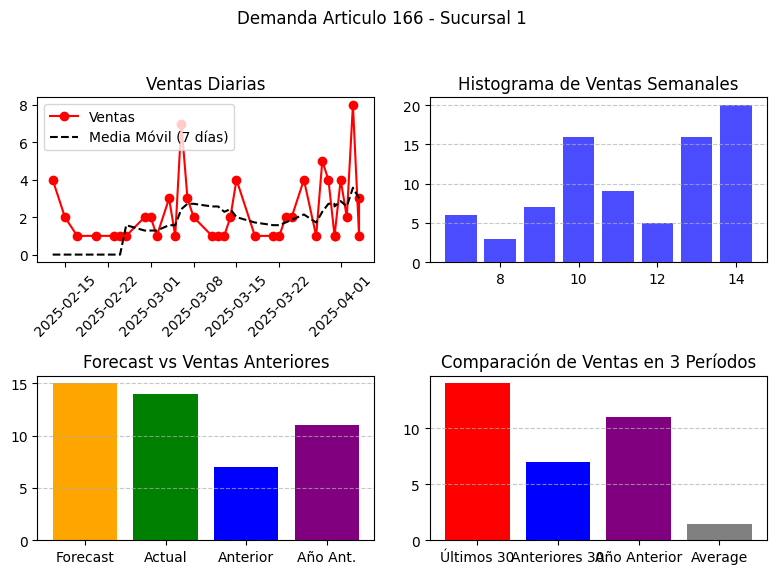

In [16]:
graficar_desde_datos_json(grafico)

### GENERAR PYTHON

In [ ]:
"""
Nombre del módulo: S30_GENERA_Grafico_Detalle.py

Descripción:
Partiendo de los datos extendidos con estado 30, se generan los gráficos de detalle para cada artículo y sucursal.
Se guarda el archivo CSV con los datos extendidos y los gráficos en formato base64.
Se actualiza el estado a 40 en la base de datos.

Autor: EWE - Zeetrex
Fecha de creación: [2025-03-22]
"""

# Solo importar lo necesario desde el módulo de funciones
from funciones_forecast import (
    get_execution_execute_by_status,
    update_execution_execute,
    generar_grafico_base64,
    generar_grafico_json
)
import os
import time
import pandas as pd  # uso localmente la lectura de archivos.
from datetime import datetime 
import traceback
import ace_tools_open as tools

from dotenv import dotenv_values
secrets = dotenv_values(".env")
folder = secrets["FOLDER_DATOS"]

def insertar_graficos_forecast(algoritmo, name, id_proveedor):
    print("📊 Insertando Gráficos Forecast:   " + name)
    start_time = time.time()

    # Paths
    path_ventas = f'{folder}/{name}_Ventas.csv'
    path_forecast = f'{folder}/{algoritmo}_Pronostico_Extendido.csv'
    path_backup = f'{folder}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv'
    path_log = f'{folder}/log_graficos_{name}.txt'

    # Cargar historial de ventas
    df_ventas = pd.read_csv(path_ventas)
    df_ventas['Codigo_Articulo'] = df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal'] = df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha'] = pd.to_datetime(df_ventas['Fecha'])

    # Cargar forecast extendido
    df_forecast = pd.read_csv(path_forecast)
    df_forecast.fillna(0, inplace=True)
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")

    # Verificar si ya existe archivo con avances
    if os.path.exists(path_backup):
        df_backup = pd.read_csv(path_backup)
        procesados = set(zip(df_backup['Codigo_Articulo'], df_backup['Sucursal']))
        print(f"🔁 Recuperando avance previo: {len(procesados)} registros ya procesados")
    else:
        df_backup = pd.DataFrame(columns=list(df_forecast.columns) + ['GRAFICO'])
        procesados = set()

    nuevos = 0
    total = len(df_forecast)

    for i, row in df_forecast.iterrows():
        clave = (row['Codigo_Articulo'], row['Sucursal'])
        if clave in procesados:
            continue

        try:
            grafico = generar_grafico_base64(
                df_ventas,
                row['Codigo_Articulo'],
                row['Sucursal'],
                row['Forecast'],
                row['Average'],
                row['ventas_last'],
                row['ventas_previous'],
                row['ventas_same_year']
            )
            row_data = row.to_dict()
            row_data['GRAFICO'] = grafico
            df_backup = pd.concat([df_backup, pd.DataFrame([row_data])], ignore_index=True)
            nuevos += 1

            if nuevos % 50 == 0 or i == total - 1:
                df_backup.to_csv(path_backup, index=False)
                elapsed = round(time.time() - start_time, 2)
                print(f"🖼️ Procesados {nuevos} nuevos registros ({i+1}/{total}) - Tiempo: {elapsed} seg")
                with open(path_log, "a", encoding="utf-8") as log:
                    log.write(f"[{datetime.now()}] {nuevos} registros procesados ({i+1}/{total}) - Tiempo: {elapsed} seg\n")

        except Exception as e:
            print(f"❌ Error procesando gráfico para Art {row['Codigo_Articulo']} - Suc {row['Sucursal']}: {e}")
            with open(path_log, "a", encoding="utf-8") as log:
                log.write(f"[{datetime.now()}] ERROR Art {row['Codigo_Articulo']} - Suc {row['Sucursal']}: {e}\n")
            continue

    # Guardar completo al final
    df_backup.to_csv(path_backup, index=False)
    elapsed = round(time.time() - start_time, 2)
    print(f"✅ Finalizado: {name} - Total nuevos: {nuevos} - Tiempo total: {elapsed} segundos")
    with open(path_log, "a", encoding="utf-8") as log:
        log.write(f"[{datetime.now()}] FINALIZADO: {nuevos} registros nuevos - Tiempo total: {elapsed} seg\n")

    return df_backup


In [ ]:
# Punto de entrada
if __name__ == "__main__":
    fes = get_execution_execute_by_status(30)

    # Filtrar registros con supply_forecast_execution_status_id = 30  #FORECAST con DFATOSK
    for index, row in fes[fes["fee_status_id"].isin([30])].iterrows():
        algoritmo = row["name"] 
        name = algoritmo.split('_ALGO')[0]
        execution_id = row["forecast_execution_id"]
        id_proveedor = row["ext_supplier_code"]
        forecast_execution_execute_id = row["forecast_execution_execute_id"]

        print(f"Algoritmo: {algoritmo}  - Name: {name}  exce_id: {execution_id}  Proveedor: {id_proveedor}")

        try:
            # Estado intermedio: 35 (procesando gráficos)
            print(f"🛠 Marcando como 'Procesando Gráficos' para {execution_id}")
            update_execution_execute(forecast_execution_execute_id, supply_forecast_execution_status_id=35)
            print(f"🛠 Iniciando graficación para {execution_id}...")

            # Generación del dataframe extendido con gráficos
            df_merged = insertar_graficos_forecast(algoritmo, name, id_proveedor)

            # Guardar el CSV con datos extendidos y gráficos
            file_path = f"{folder}/{algoritmo}_Pronostico_Extendido.csv"
            df_merged.to_csv(file_path, index=False)
            print(f"📁 Archivo guardado correctamente: {file_path}")

            # ✅ Solo si todo fue exitoso, actualizamos el estado a 40
            update_execution_execute(forecast_execution_execute_id, supply_forecast_execution_status_id=40)
            print(f"✅ Estado actualizado a 40 para {execution_id}")

        except Exception as e:
            traceback.print_exc()
            print(f"❌ Error procesando {name}: {e}")
            
            log_path = os.path.join(folder, "errores_s30.log")
            with open(log_path, "a", encoding="utf-8") as log_file:
                log_file.write(f"[{name}] ID: {execution_id} - ERROR: {str(e)}\n")
            
            continue

### NUEVO ENFOQUE

* PLOTLY
* PARALELIZADO
* PRECALCULO de los DATAFRAMES

*Mejora	Implementada*
* Pre-filtrado de datos	✅
* Cache por combinación	✅
* Multiprocesamiento	✅
* Migración a Plotly	✅
* Exportación Base64	✅

Ya he migrado el módulo S30_GENERA_Grafico_Detalle.py al nuevo enfoque que incluye:

✅ Precálculo de los dataframes por producto y sucursal.

✅ Paralelización con multiprocessing para mejorar la performance.

✅ Uso de la nueva función generar_grafico_base64_plotly con Plotly para generación de gráficos.

✅ Soporte para recuperación de avance previo y persistencia incremental.

✅ Registro en archivo de log y manejo robusto de errores.

In [ ]:
import traceback
import os
import time
from datetime import datetime
from multiprocessing import Pool, cpu_count

import pandas as pd
from dotenv import dotenv_values

from funciones_forecast import (
    get_execution_execute_by_status,
    update_execution_execute,
    generar_grafico_base64_plotly,   # Se asume que esta es la nueva función con Plotly
    generar_grafico_json
    
)

secrets = dotenv_values(".env")
folder = secrets["FOLDER_DATOS"]

def procesar_item(args):
    articulo, sucursal, df_filtrado, Forecast, Average, ventas_last, ventas_previous, ventas_same_year, index = args
    try:
        grafico = generar_grafico_base64_plotly(
            df_filtrado, articulo, sucursal,
            Forecast, Average, ventas_last, ventas_previous, ventas_same_year
        )
        return index, {
            'Codigo_Articulo': articulo,
            'Sucursal': sucursal,
            'Forecast': Forecast,
            'Average': Average,
            'ventas_last': ventas_last,
            'ventas_previous': ventas_previous,
            'ventas_same_year': ventas_same_year,
            'GRAFICO': grafico
        }
    except Exception as e:
        print(f"❌ Error en {articulo}-{sucursal}: {e}")
        return index, None

def insertar_graficos_forecast(algoritmo, name, id_proveedor):
    print("📊 Insertando Gráficos Forecast:   " + name)
    start_time = time.time()

    path_ventas = f'{folder}/{name}_Ventas.csv'
    path_forecast = f'{folder}/{algoritmo}_Pronostico_Extendido.csv'
    path_backup = f'{folder}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv'
    path_log = f'{folder}/log_graficos_{name}.txt'

    df_ventas = pd.read_csv(path_ventas)
    df_ventas['Codigo_Articulo'] = df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal'] = df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha'] = pd.to_datetime(df_ventas['Fecha'])

    df_forecast = pd.read_csv(path_forecast)
    df_forecast.fillna(0, inplace=True)
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")

    if os.path.exists(path_backup):
        df_backup = pd.read_csv(path_backup)
        procesados = set(zip(df_backup['Codigo_Articulo'], df_backup['Sucursal']))
        print(f"🔁 Recuperando avance previo: {len(procesados)} registros ya procesados")
    else:
        df_backup = pd.DataFrame(columns=list(df_forecast.columns) + ['GRAFICO'])
        procesados = set()

    fecha_max = df_ventas['Fecha'].max()
    lista_args = []
    for i, row in df_forecast.iterrows():
        clave = (row['Codigo_Articulo'], row['Sucursal'])
        if clave in procesados:
            continue

        df_filt = df_ventas[
            (df_ventas['Codigo_Articulo'] == row['Codigo_Articulo']) &
            (df_ventas['Sucursal'] == row['Sucursal']) &
            (df_ventas['Fecha'] >= fecha_max - pd.Timedelta(days=50))
        ].copy()

        lista_args.append((
            row['Codigo_Articulo'], row['Sucursal'], df_filt,
            row['Forecast'], row['Average'],
            row['ventas_last'], row['ventas_previous'], row['ventas_same_year'], i
        ))

    nuevos = 0
    total = len(lista_args)
    buffer_registros = []

    with Pool(processes=cpu_count()) as pool:
        for index, result in pool.imap_unordered(procesar_item, lista_args):
            if result:
                buffer_registros.append(result)
                nuevos += 1

            if nuevos % 50 == 0 or nuevos == total:
                if buffer_registros:
                    df_buffer = pd.DataFrame(buffer_registros)
                    df_backup = pd.concat([df_backup, df_buffer], ignore_index=True)
                    df_backup.to_csv(path_backup, index=False)
                    buffer_registros = []

                    elapsed = round(time.time() - start_time, 2)
                    print(f"🖼️ Procesados {nuevos} nuevos registros ({nuevos}/{total}) - Tiempo: {elapsed} seg")
                    with open(path_log, "a", encoding="utf-8") as log:
                        log.write(f"[{datetime.now()}] {nuevos} registros procesados ({nuevos}/{total}) - Tiempo: {elapsed} seg\n")

    df_backup.to_csv(path_backup, index=False)
    elapsed = round(time.time() - start_time, 2)
    print(f"✅ Finalizado: {name} - Total nuevos: {nuevos} - Tiempo total: {elapsed} segundos")
    with open(path_log, "a", encoding="utf-8") as log:
        log.write(f"[{datetime.now()}] FINALIZADO: {nuevos} registros nuevos - Tiempo total: {elapsed} seg\n")

    return df_backup

if __name__ == "__main__":
    fes = get_execution_execute_by_status(30)

    for index, row in fes[fes["fee_status_id"].isin([30])].iterrows():
        algoritmo = row["name"] 
        name = algoritmo.split('_ALGO')[0]
        execution_id = row["forecast_execution_id"]
        id_proveedor = row["ext_supplier_code"]
        forecast_execution_execute_id = row["forecast_execution_execute_id"]

        print(f"Algoritmo: {algoritmo}  - Name: {name}  exce_id: {execution_id}  Proveedor: {id_proveedor}")

        try:
            print(f"🛠 Marcando como 'Procesando Gráficos' para {execution_id}")
            update_execution_execute(forecast_execution_execute_id, supply_forecast_execution_status_id=35)
            print(f"🛠 Iniciando graficación para {execution_id}...")

            df_merged = insertar_graficos_forecast(algoritmo, name, id_proveedor)

            file_path = f"{folder}/{algoritmo}_Pronostico_Extendido_FINAL.csv"
            df_merged.to_csv(file_path, index=False)
            print(f"📁 Archivo guardado correctamente: {file_path}")

            update_execution_execute(forecast_execution_execute_id, supply_forecast_execution_status_id=40)
            print(f"✅ Estado actualizado a 40 para {execution_id}")

        except Exception as e:
            traceback.print_exc()
            print(f"❌ Error procesando {name}: {e}")

            log_path = os.path.join(folder, "errores_s30.log")
            with open(log_path, "a", encoding="utf-8") as log_file:
                log_file.write(f"[{name}] ID: {execution_id} - ERROR: {str(e)}\n")

            continue



Algoritmo: 596_PROCTER_ALGO_01  - Name: 596_PROCTER  exce_id: 9737c740-ba85-462f-b446-d61905e3d048  Proveedor: 596
🛠 Marcando como 'Procesando Gráficos' para 9737c740-ba85-462f-b446-d61905e3d048
🛠 Iniciando graficación para 9737c740-ba85-462f-b446-d61905e3d048...
📊 Insertando Gráficos Forecast:   596_PROCTER
-> Datos Recuperados del CACHE: 596, Label: 596_PROCTER
🔁 Recuperando avance previo: 0 registros ya procesados


In [ ]:
# df_forecast.info()

In [ ]:
from funciones_forecast import (
    get_execution_execute_by_status,
    update_execution_execute,
    generar_grafico_base64
)
import os
import time
import pandas as pd  # uso localmente la lectura de archivos.
from datetime import datetime 
import traceback
import ace_tools_open as tools

from dotenv import dotenv_values
secrets = dotenv_values(".env")
folder = secrets["FOLDER_DATOS"]


fes = get_execution_execute_by_status(40)

# Mostrar la tabla con los gráficos en base64

tools.display_dataframe_to_user(name="Forecast execution by STATUS", dataframe=fes)

In [ ]:
# Requiere: pandas, plotly, kaleido (para exportar imágenes)
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from io import BytesIO
import base64
from multiprocessing import Pool, cpu_count

# Suponiendo que dfv es el DataFrame original con columnas: 
# "Codigo_Articulo", "Sucursal", "Fecha", "Unidades"

# -------------------------------
# 1. FUNCIÓN PARA GENERAR GRÁFICO
# -------------------------------

def generar_grafico_base64_plotly(df_filtrado, articulo, sucursal, Forecast, Average, ventas_last, ventas_previous, ventas_same_year):
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Ventas Diarias",
            "Histograma de Ventas Semanales",
            "Forecast vs Ventas Anteriores",
            "Comparación de Ventas en 3 Períodos"
        )
    )

    fig.update_layout(title_text=f"Demanda Articulo {articulo} - Sucursal {sucursal}", height=800, width=1000)

    # Media móvil
    df_filtrado["Media_Movil"] = df_filtrado["Unidades"].rolling(window=7).mean()

    # Gráfico 1
    fig.add_trace(go.Scatter(x=df_filtrado["Fecha"], y=df_filtrado["Unidades"], mode='lines+markers', name='Ventas'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_filtrado["Fecha"], y=df_filtrado["Media_Movil"], mode='lines', name='Media Móvil', line=dict(dash='dash')), row=1, col=1)

    # Gráfico 2
    df_filtrado["Semana"] = df_filtrado["Fecha"].dt.to_period("W").astype(str)
    df_semanal = df_filtrado.groupby("Semana").agg({"Unidades": "sum", "Fecha": "min"}).reset_index()
    df_semanal["Semana_Num"] = df_semanal["Fecha"].dt.isocalendar().week
    fig.add_trace(go.Bar(x=df_semanal["Semana_Num"], y=df_semanal["Unidades"], name="Semanas"), row=1, col=2)

    # Gráfico 3
    fig.add_trace(go.Bar(x=["Forecast", "Actual", "Anterior", "Año Ant"],
                        y=[Forecast, ventas_last, ventas_previous, ventas_same_year],
                        name="Comparación"), row=2, col=1)

    # Gráfico 4: cálculo períodos
    fecha_maxima = df_filtrado["Fecha"].max()
    fecha_inicio_ultimos30 = fecha_maxima - pd.Timedelta(days=30)
    fecha_inicio_previos30 = fecha_inicio_ultimos30 - pd.Timedelta(days=30)
    fecha_inicio_anio_anterior = fecha_inicio_ultimos30 - pd.DateOffset(years=1)
    fecha_fin_anio_anterior = fecha_inicio_previos30 - pd.DateOffset(years=1)

    ventas_ultimos_30 = df_filtrado[df_filtrado["Fecha"] > fecha_inicio_ultimos30]["Unidades"].sum()
    ventas_previos_30 = df_filtrado[
        (df_filtrado["Fecha"] > fecha_inicio_previos30) & (df_filtrado["Fecha"] <= fecha_inicio_ultimos30)
    ]["Unidades"].sum()
    df_anterior = df_filtrado.copy()
    df_anterior["Fecha"] = df_anterior["Fecha"] - pd.DateOffset(years=1)
    ventas_anio_anterior = df_anterior[
        (df_anterior["Fecha"] > fecha_inicio_anio_anterior) & (df_anterior["Fecha"] <= fecha_fin_anio_anterior)
    ]["Unidades"].sum()

    fig.add_trace(go.Bar(x=["Últimos 30", "Anteriores 30", "Año anterior", "Average"],
                        y=[ventas_ultimos_30, ventas_previos_30, ventas_anio_anterior, Average],
                        name="Comparación temporal"), row=2, col=2)

    # Exportar a base64
    buffer = BytesIO()
    fig.write_image(buffer, format="png")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# -------------------------------
# 2. FUNCIÓN DE PROCESO INDIVIDUAL
# -------------------------------

def procesar_item(args):
    articulo, sucursal, df_filtrado, Forecast, Average, ventas_last, ventas_previous, ventas_same_year = args
    try:
        return (articulo, sucursal, generar_grafico_base64_plotly(
            df_filtrado, articulo, sucursal,
            Forecast, Average, ventas_last, ventas_previous, ventas_same_year
        ))
    except Exception as e:
        print(f"Error en {articulo}-{sucursal}: {e}")
        return (articulo, sucursal, None)

# -------------------------------
# 3. PRECALCULAR DATAFRAMES FILTRADOS
# -------------------------------

def preparar_y_procesar(dfv, resumen_ventas):
    fecha_maxima = dfv["Fecha"].max()

    # Precálculo por producto-sucursal
    pares = dfv[["Codigo_Articulo", "Sucursal"]].drop_duplicates()
    dict_df = {}
    for row in pares.itertuples(index=False):
        df_filt = dfv[
            (dfv["Codigo_Articulo"] == row.Codigo_Articulo) &
            (dfv["Sucursal"] == row.Sucursal) &
            (dfv["Fecha"] >= fecha_maxima - pd.Timedelta(days=50))
        ].copy()
        dict_df[(row.Codigo_Articulo, row.Sucursal)] = df_filt

    # Empaquetar datos de entrada
    lista_entradas = []
    for (articulo, sucursal), df_filtrado in dict_df.items():
        # Obtener métricas simuladas para el ejemplo
        Forecast = resumen_ventas.get((articulo, sucursal), {}).get("Forecast", 0)
        Average = resumen_ventas.get((articulo, sucursal), {}).get("Average", 0)
        ventas_last = resumen_ventas.get((articulo, sucursal), {}).get("Last", 0)
        ventas_previous = resumen_ventas.get((articulo, sucursal), {}).get("Previous", 0)
        ventas_same_year = resumen_ventas.get((articulo, sucursal), {}).get("SameYear", 0)

        lista_entradas.append((
            articulo, sucursal, df_filtrado,
            Forecast, Average, ventas_last, ventas_previous, ventas_same_year
        ))

    # Multiprocesamiento
    with Pool(processes=cpu_count()) as pool:
        resultados = pool.map(procesar_item, lista_entradas)

    # Retorno en dict
    return {(art, suc): b64img for art, suc, b64img in resultados if b64img is not None}


In [ ]:
for index, row in fes[fes["fee_status_id"] == 40].iterrows():
    algoritmo = row["name"]
    name = algoritmo.split('_ALGO')[0]
    execution_id = row["forecast_execution_id"]
    id_proveedor = row["ext_supplier_code"]
    print("Algoritmo: " + algoritmo + "  - Name: " + name + " exce_id:" + str(execution_id) + " id: Proveedor "+id_proveedor)

    print("📊 Insertando Gráficos Forecast:   " + name)
    start_time = time.time()

    # Paths
    path_ventas = f'{folder}/{name}_Ventas.csv'
    path_forecast = f'{folder}/{algoritmo}_Pronostico_Extendido.csv'
    path_backup = f'{folder}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv'
    path_log = f'{folder}/log_graficos_{name}.txt'

    # Cargar historial de ventas
    df_ventas = pd.read_csv(path_ventas)
    df_ventas['Codigo_Articulo'] = df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal'] = df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha'] = pd.to_datetime(df_ventas['Fecha'])

    # Cargar forecast extendido
    df_forecast = pd.read_csv(path_forecast)
    df_forecast.fillna(0, inplace=True)
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")

In [ ]:
nuevos = 0
total = len(df_forecast)
    
for i, row in df_forecast.iterrows():
        # clave = (row['Codigo_Articulo'], row['Sucursal'])
        # if clave in procesados:
        #     continue

        try:
            grafico = generar_grafico_base64(
                df_ventas,
                row['Codigo_Articulo'],
                row['Sucursal'],
                row['Forecast'],
                row['Average'],
                row['ventas_last'],
                row['ventas_previous'],
                row['ventas_same_year']
            )
            row_data = row.to_dict()
            row_data['GRAFICO'] = grafico
            df_backup = pd.concat([df_backup, pd.DataFrame([row_data])], ignore_index=True)
            nuevos += 1

            if nuevos % 50 == 0 or i == total - 1:
                df_backup.to_csv(path_backup, index=False)
                elapsed = round(time.time() - start_time, 2)
                print(f"🖼️ Procesados {nuevos} nuevos registros ({i+1}/{total}) - Tiempo: {elapsed} seg")
                with open(path_log, "a", encoding="utf-8") as log:
                    log.write(f"[{datetime.now()}] {nuevos} registros procesados ({i+1}/{total}) - Tiempo: {elapsed} seg\n")

        except Exception as e:
            print(f"❌ Error procesando gráfico para Art {row['Codigo_Articulo']} - Suc {row['Sucursal']}: {e}")
            with open(path_log, "a", encoding="utf-8") as log:
                log.write(f"[{datetime.now()}] ERROR Art {row['Codigo_Articulo']} - Suc {row['Sucursal']}: {e}\n")
            continue